In [1]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision.models import resnet18
from torch import nn, optim
from sklearnex import patch_sklearn
from PIL import Image
from copy import copy
patch_sklearn()
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as CMD

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Setting computing device

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


### Loading Dataset

In [3]:
if 'google.colab' in str(get_ipython()):
  drive.mount('/content/drive')
  !cp -v /content/drive/My\ Drive/Datasets/Tomato.zip .
  !mkdir Tomato
  !unzip -q Tomato.zip -d ./Tomato
  !rm Tomato.zip
  DATA_ROOT = "./Tomato"
else:
  DATA_ROOT = "../Datasets/Tomato"

In [4]:
!ls ../Datasets/Tomato

 Tomato___Early_blight	      'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	       Tomato___Target_Spot
 Tomato___Late_blight	       Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	       Tomato___Tomato_Yellow_Leaf_Curl_Virus
 Tomato___Septoria_leaf_spot


Utilizando a classe ImageFolder para carregar o dataset. É necessário que as imagens estejam separadas em pastas correspondentes a cada classe. Mais detalhes: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [5]:
dataset = ImageFolder(DATA_ROOT,
                      transform=T.Compose([T.RandomCrop(size=(160, 160)),
                                           T.RandomRotation(degrees=(0, 360)),
                                           T.ToTensor()]))

#### Splitting data into Train, Test and Validation sets

Separando 70% dos dados para treino, 25% para teste e 5% para validação.

O random_split requer uma lista com a quantidade dos dados contidos em cada um dos splits, de forma que a soma dos valores fornecidos seja exatamente igual ao tamanho do dataset completo.

In [6]:
train_set, test_set, val_set = random_split(
    dataset,
    [int(len(dataset) * 0.7),
     int(len(dataset) * 0.25),
     len(dataset) - int(len(dataset) * 0.7) - int(len(dataset) * 0.25)]
)

In [7]:
print(f'Full Set Len: {len(dataset)}')
print(f'Train Set Len: {len(train_set)}')
print(f'Test Set Len: {len(test_set)}')
print(f'Validation Set Len: {len(val_set)}')

Full Set Len: 16708
Train Set Len: 11695
Test Set Len: 4177
Validation Set Len: 836


## Visualizing Data

#### Original dataset images

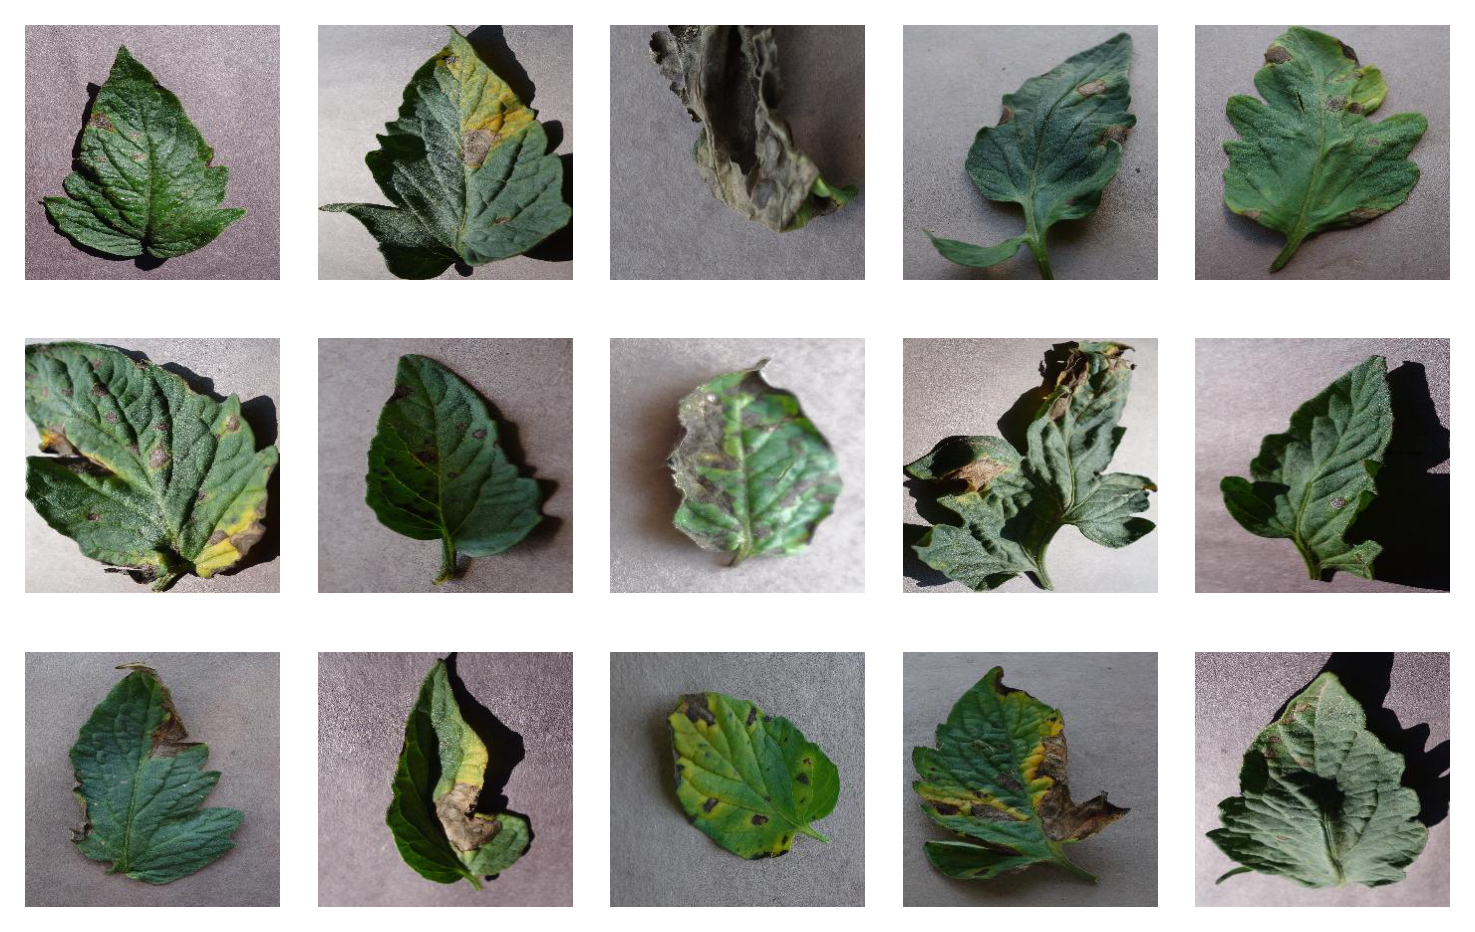

In [8]:
_, axs = plt.subplots(3, 5, dpi=250, tight_layout=True)

for idx, ax in enumerate(axs.flatten()):
  img = Image.open(dataset.imgs[idx][0]).convert('RGB')
  ax.imshow(img)
  ax.axis('off')

plt.show()
plt.close()

#### Dataset images after transformations

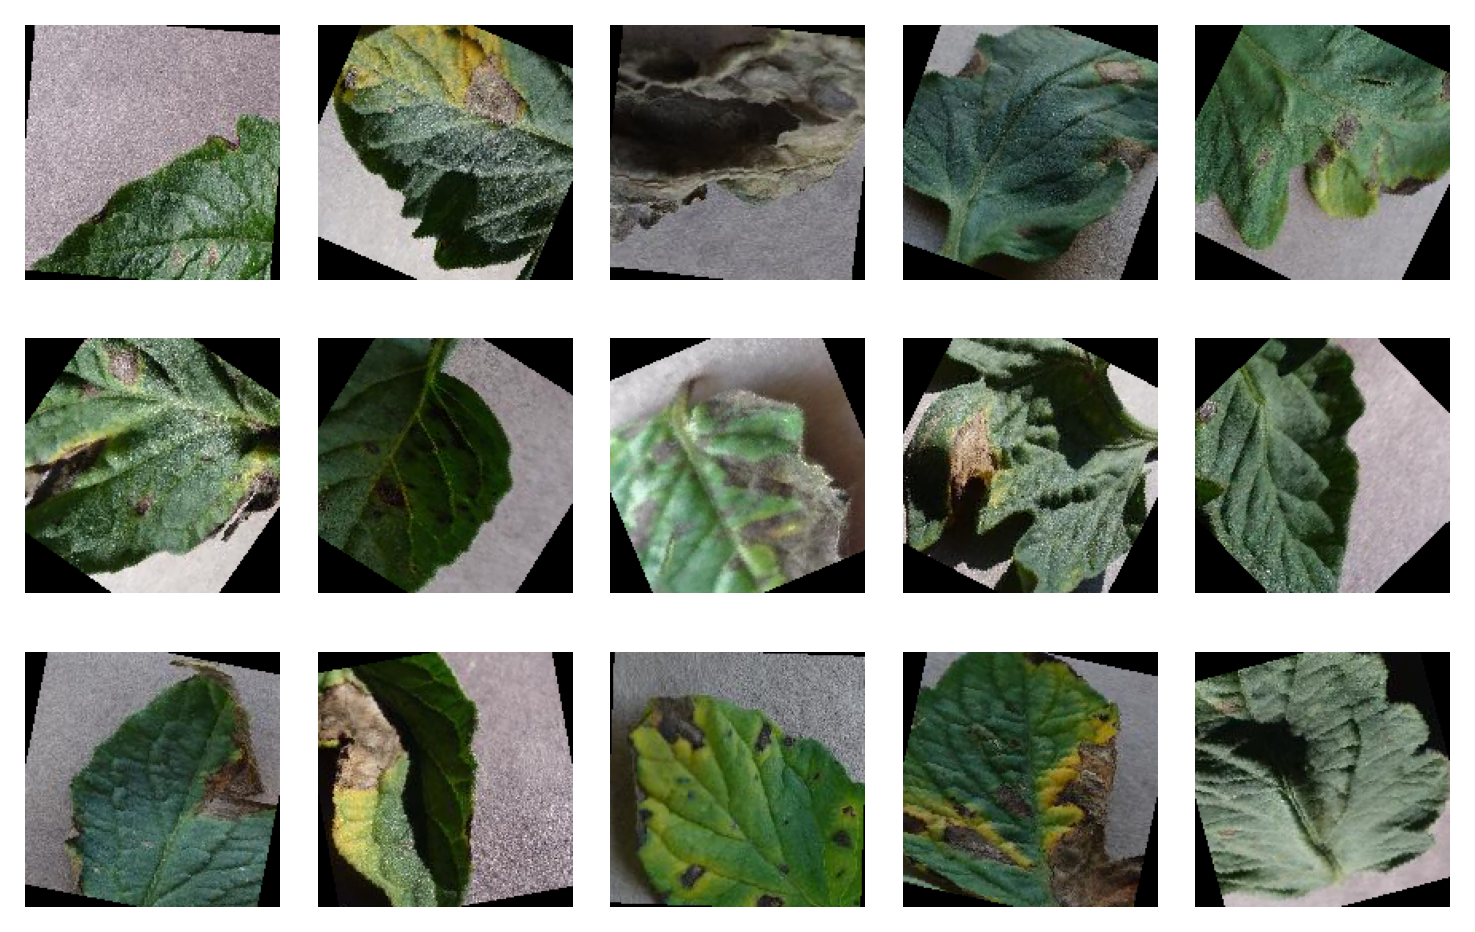

In [9]:
_, axs = plt.subplots(3, 5, dpi=250, tight_layout=True)

for idx, ax in enumerate(axs.flatten()):
  img = T.ToPILImage()(dataset[idx][0])
  ax.imshow(img)
  ax.axis('off')

plt.show()
plt.close()

Classes e seus indices correspondentes, identificados automaticamente pelo ImageFolder.

In [10]:
dataset.class_to_idx

{'Tomato___Early_blight': 0,
 'Tomato___Late_blight': 1,
 'Tomato___Leaf_Mold': 2,
 'Tomato___Septoria_leaf_spot': 3,
 'Tomato___Spider_mites Two-spotted_spider_mite': 4,
 'Tomato___Target_Spot': 5,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 6,
 'Tomato___Tomato_mosaic_virus': 7,
 'Tomato___healthy': 8}

Distribuição das classes do dataset

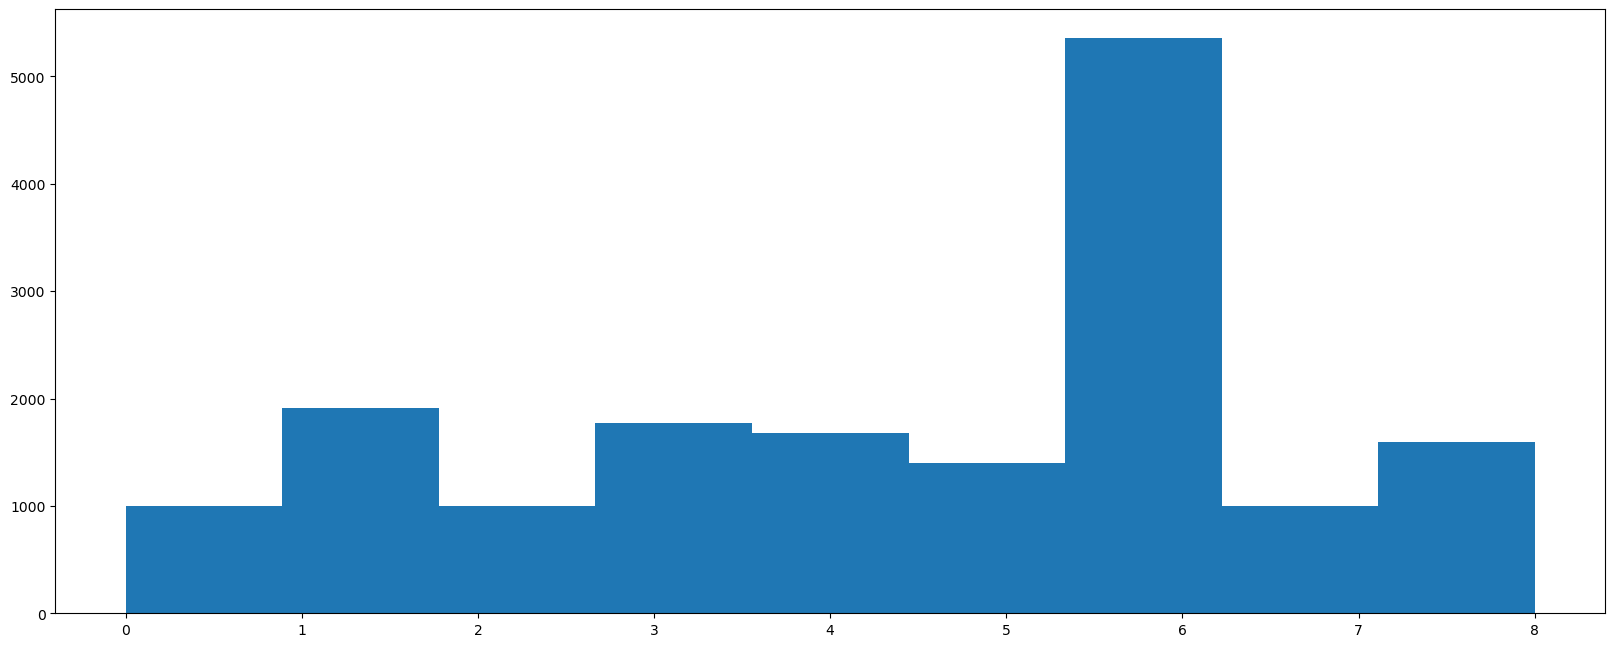

In [11]:
fig = plt.figure(figsize=(20, 8), dpi=100)
plt.hist(dataset.targets, bins=len(set(dataset.targets)))
plt.show()
plt.close()

### Defining DataLoaders

In [12]:
train_loader = DataLoader(dataset=train_set,
                          num_workers=4,
                          shuffle=True,
                          batch_size=128,
                          pin_memory=True)

test_loader = DataLoader(dataset=test_set,
                         num_workers=4,
                         shuffle=True,
                         batch_size=256,
                         pin_memory=True)

val_loader = DataLoader(dataset=val_set,
                        num_workers=4,
                        shuffle=True,
                        batch_size=256,
                        pin_memory=True)

## Defining Model

In [13]:
model = resnet18(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Como podemos ver acima, a última camada do modelo possui 1000 saídas. Como o nosso dataset tem apenas 9 classes, alteramos a quantidade de saídas do modelo para apenas 9.

### Updating last layer to have only 9 outputs, as it is the number of classes on the dataset we're using

In [14]:
model.fc = nn.Linear(in_features=512, out_features=9, bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training and Testing

Script de treinamento com early stopping.

In [15]:
def train(model, train_loader, val_loader, epochs):
  model = model.to(DEVICE)
  learning_rate = 1e-4
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  loss_fn = nn.CrossEntropyLoss()
  best_loss = 1e12

  val_counter = 2
  train_bar = tqdm(range(epochs))
  train_loss, train_acc = [], []
  val_loss, val_acc = [], []
  for epoch in train_bar:
    model.train()

    acc, epoch_loss = 0, 0
    
    for imgs, labels in train_loader:
      model.zero_grad()

      imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

      output = model(imgs)
      batch_loss = loss_fn(output, labels)
      batch_loss.backward()
      optimizer.step()

      epoch_loss += batch_loss.item()
      acc += accuracy_score(torch.argmax(output, dim=1).tolist(),
                            labels.detach().cpu().numpy())

    epoch_loss /= len(train_loader)
    acc /= len(train_loader)
    train_acc.append(acc)
    train_loss.append(epoch_loss)

    acc, epoch_loss = 0, 0

    model.eval()

    for imgs, labels in val_loader:
      model.zero_grad()

      imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

      with torch.inference_mode():
        output = model(imgs)
      batch_loss = loss_fn(output, labels)

      epoch_loss += batch_loss.item()
      acc += accuracy_score(torch.argmax(output, dim=1).tolist(),
                            labels.tolist())

    epoch_loss /= len(val_loader)
    acc /= len(val_loader)
    val_acc.append(acc)
    val_loss.append(epoch_loss)
    
    train_bar.set_description(f'Epoch: {epoch+1}/{epochs}) - '
                              f'Train Loss: {train_loss[-1]:.03f} - '
                              f'Val Loss: {val_loss[-1]:.03f} - '
                              f'Train Acc: {(100 * train_acc[-1]):.02f}% - '
                              f'Val Acc: {(100 * val_acc[-1]):.02f}%')

    if best_loss > epoch_loss:
      val_counter = 2
      best_loss = epoch_loss
      best_model = model
    else:
      val_counter -= 1

    if val_counter == 0:
      break
    
  _, axs = plt.subplots(1, 2, dpi=100, tight_layout=True, figsize=(8, 3))
  axs[0].plot(range(len(train_loss)), train_loss, label='Train Loss')
  axs[0].plot(range(len(val_loss)), val_loss, label='Val Loss')
  axs[0].legend()  
  axs[1].plot(range(len(train_loss)), train_acc, label='Train Accuracy')
  axs[1].plot(range(len(val_loss)), val_acc, label='Val Accuracy')
  axs[1].legend()
  plt.show()
  plt.close()

  return best_model

Script de teste.

In [16]:
def test(model, test_loader):
    model.zero_grad()
    model.eval()
    model = model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    
    acc, epoch_loss = 0, 0
    all_outputs, all_labels = [], []
    for imgs, labels in tqdm(test_loader):
      imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

      with torch.inference_mode():
        output = model(imgs)
        
      all_outputs.extend(torch.argmax(output, dim=1).tolist())
      all_labels.extend(labels.tolist())
      batch_loss = loss_fn(output, labels)

      epoch_loss += batch_loss
      acc += accuracy_score(torch.argmax(output, dim=1).tolist(),
                            labels.tolist())
    
    disp = CMD(confusion_matrix=cm(all_labels,
                                   all_outputs,
                                   labels=list(set(all_labels))),
               display_labels=set(all_labels))
    disp.plot()
    plt.show()
    plt.close()
    
    acc /= len(test_loader)
    print(f'Test Accuracy: {(100 * acc):.02f}%')

Treinando o modelo sem pré treinamento por 5 épocas.

Epoch: 5/5) - Train Loss: 0.358 - Val Loss: 0.762 - Train Acc: 87.67% - Val Acc: 74.38%: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:59<00:00, 23.95s/it]


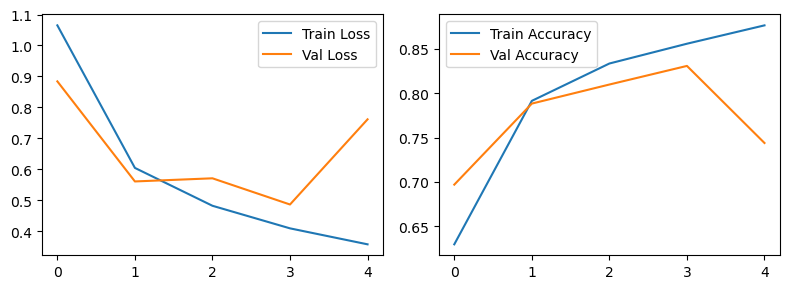

CPU times: user 1min 58s, sys: 3.62 s, total: 2min 1s
Wall time: 2min 1s


In [17]:
%%time
model = train(model, train_loader, val_loader, epochs=5)

Avaliando o modelo.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  4.79it/s]


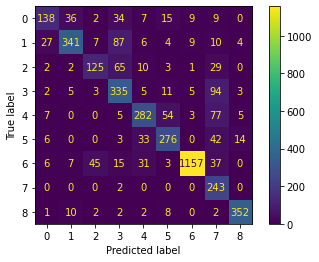

Test Accuracy: 77.93%


In [18]:
test(model, test_loader)

Treinando o modelo pré treinado, por 5 épocas.

In [19]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=9, bias=True)

Epoch: 5/5) - Train Loss: 0.068 - Val Loss: 0.093 - Train Acc: 97.71% - Val Acc: 96.46%: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:01<00:00, 24.29s/it]


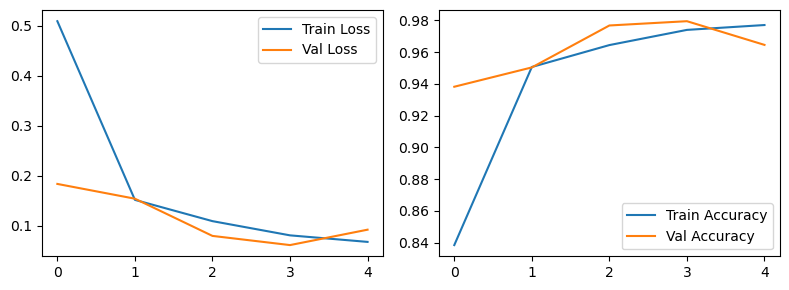

CPU times: user 1min 58s, sys: 3.48 s, total: 2min 2s
Wall time: 2min 1s


In [20]:
%%time
model = train(model, train_loader, val_loader, epochs=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.16it/s]


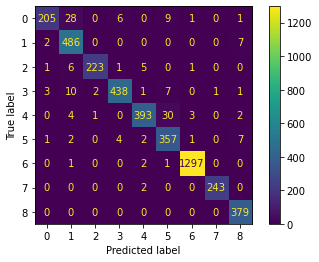

Test Accuracy: 96.22%


In [21]:
test(model, test_loader)

Como podemos observar, após o treinamento o modelo pré treinado apresentou um desempenho muito superior ao modelo sem pré treinamento, mesmo ambos tendo sido treinados por 5 épocas.

Quando estivermos satisfeitos com a performance obtida pelo treinamento, podemos salvar o nosso modelo para utilizá-lo depois em uma aplicação.

In [22]:
torch.save(model.state_dict(), "./model.pt")

### Inference

Tendo um modelo já treinado, podemos utilizá-lo para fazer inferências. Para isso, precisamos instanciar uma rede com a mesma estrutura do modelo treinado, no nosso caso uma resnet18 com 9 saídas, e importar os pesos obtidos no treinamento.

In [23]:
model = resnet18()
model.fc = nn.Linear(in_features=512, out_features=9, bias=True)

model_file = torch.load('./model.pt')
model.load_state_dict(model_file)

<All keys matched successfully>

In [24]:
dataset.class_to_idx

{'Tomato___Early_blight': 0,
 'Tomato___Late_blight': 1,
 'Tomato___Leaf_Mold': 2,
 'Tomato___Septoria_leaf_spot': 3,
 'Tomato___Spider_mites Two-spotted_spider_mite': 4,
 'Tomato___Target_Spot': 5,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 6,
 'Tomato___Tomato_mosaic_virus': 7,
 'Tomato___healthy': 8}

Para fazer a inferência, precisamos garantir que os dados estejam no mesmo formato utilizado para o treinamento do modelo. No nosso caso, as imagens do dataset possuem resolução 256x256 e foram usados crops de 160x160.

Além disso, precisamos lembrar que o modelo recebe um batch de imagens como entrada, entao para fazer a inferencia de uma unica imagem precisamos fazer a operação de unsqueeze(0), que vai adicionar uma dimensão na posição 0 do tensor da imagem. Isso quer dizer que teremos um batch de tamanho 1.

In [25]:
def inference(model, img):
    model.zero_grad()
    model.eval()
    model = model.to(DEVICE)
    
    with torch.inference_mode():
        input_img = T.RandomCrop(size=(160, 160))(img)
        input_img = T.ToTensor()(input_img)
        
        input_img = input_img.to(DEVICE)
        output = model(input_img.unsqueeze(0))
        
    class_idx = torch.argmax(output, dim=1).item()

    return class_idx

In [ ]:
Carregando imagens e fazendo a inferência. 

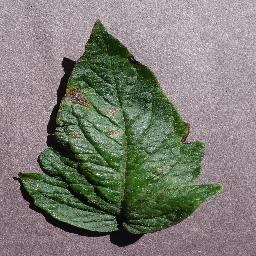

Image Class: 0


In [26]:
test_img = Image.open('../Datasets/early_blight.jpg')
display(test_img)
print(f'Image Class: {inference(model, test_img)}')

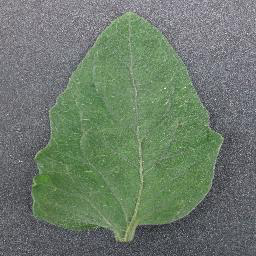

Image Class: 8


In [27]:
test_img = Image.open('../Datasets/healthy_tomato.jpg')
display(test_img)
print(f'Image Class: {inference(model, test_img)}')